In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

houses = pd.read_csv('data/austinHousingData.csv')
properties = ['zipcode', 
              'homeType', 
              'latestPrice',
              'propertyTaxRate', 
              'numOfBedrooms', 
              'avgSchoolDistance', 
              'avgSchoolRating', 
              'MedianStudentsPerTeacher']
data = houses[properties].copy()
data.head()

,zipcode,homeType,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
0,78660,Single Family,305000.0,1.98,4,1.266667,2.666667,14
1,78660,Single Family,295000.0,1.98,4,1.400000,2.666667,14
2,78660,Single Family,256125.0,1.98,3,1.200000,3.000000,14
3,78660,Single Family,240000.0,1.98,3,1.400000,2.666667,14
4,78660,Single Family,239900.0,1.98,3,1.133333,4.000000,14


In [2]:
# Exploration and preprocessing

# encode categorical data
from sklearn.preprocessing import LabelEncoder

data = data.apply(LabelEncoder().fit_transform)
data.head()

,zipcode,homeType,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
0,4,7,698,0,4,67,1,4
1,4,7,652,0,4,74,1,4
2,4,7,487,0,3,61,2,4
3,4,7,427,0,3,74,1,4
4,4,7,420,0,3,58,6,4


In [3]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(threshold=0.25)
var_thresh.fit(data)
var_thresh.get_support()
con_cols = [col for col in data.columns if col not in data.columns[var_thresh.get_support()]]
data = data.drop(con_cols, axis=1)
data.head()

,zipcode,homeType,latestPrice,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
0,4,7,698,4,67,1,4
1,4,7,652,4,74,1,4
2,4,7,487,3,61,2,4
3,4,7,427,3,74,1,4
4,4,7,420,3,58,6,4


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaled_data.shape[1])
pca.fit(scaled_data)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)


In [6]:
# Select the number of components based on the desired explained variance threshold
desired_explained_variance = 0.95
num_components = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

# Output the selected number of components
print(f"Number of components to explain {desired_explained_variance:.2f} variance: {num_components}")

# Fit PCA with the selected number of components
pca = PCA(n_components=num_components)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_data), columns=[f"PC{i+1}" for i in range(num_components)])

Number of components to explain 0.95 variance: 6


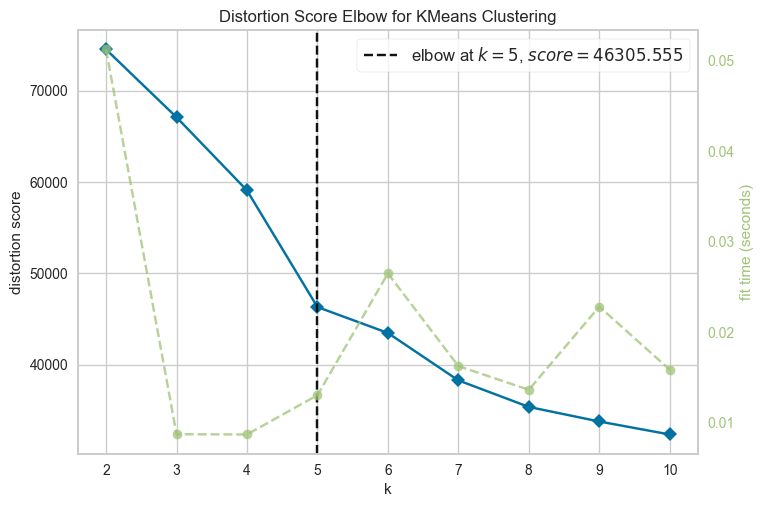

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Initialize the KElbowVisualizer with the KMeans estimator and a range of K values
Elbow_M = KElbowVisualizer(KMeans(), k=10)

# Fit the visualizer to the PCA-transformed data
Elbow_M.fit(PCA_ds)

# Display the Elbow Method plot
Elbow_M.show()

In [15]:
model_5 = KMeans(5, max_iter=1000)
pred = model_5.fit_predict(PCA_ds)

yhat_KM_k5 = model_5.fit_predict(PCA_ds)

PCA_ds_k5 = PCA_ds.copy()
data_k5 = data.copy()
PCA_ds_k5["Cluster"] = yhat_KM_k5
data_k5["Cluster"] = yhat_KM_k5

In [21]:
data_k5

,zipcode,homeType,latestPrice,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher,Cluster
0,4,7,698,4,67,1,4,4
1,4,7,652,4,74,1,4,4
2,4,7,487,3,61,2,4,4
3,4,7,427,3,74,1,4,4
4,4,7,420,3,58,6,4,4
...,...,...,...,...,...,...,...,...
15166,37,7,807,3,44,3,4,1
15167,31,7,1510,3,109,16,6,2
15168,8,7,1965,3,37,9,3,4
15169,13,3,1133,4,69,16,5,3
